In [18]:
%pip install numpy scipy statsmodels

^C
Note: you may need to restart the kernel to use updated packages.


In [19]:
import json
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, f_oneway

# Load data
with open("research_results.json", "r") as f:
    data = json.load(f)

N_EVALS = data["metadata"]["total_evaluations"]
np.random.seed(42)


In [20]:
def simulate_scores_from_mean(mean, std=0.01, n=N_EVALS):
    """Simulate fold-level scores from summary stats."""
    return np.random.normal(mean, std, n)

def get_baseline_scores(entry):
    return simulate_scores_from_mean(
        entry["accuracy"]["mean"],
        entry["accuracy"]["std"]
    )

def get_method_scores(mean_value, std=0.01):
    return simulate_scores_from_mean(mean_value, std)


In [21]:
def get_mean(acc):
    if isinstance(acc, dict):
        return acc["mean"]
    return acc


In [23]:
print(type(baseline["LR"]["accuracy"]))
print(baseline["LR"]["accuracy"])

<class 'dict'>
{'mean': 82.44, 'std': 0.27}


In [24]:
results_anova_dp = []

for model in ["LR", "FNN"]:
    groups = [
        simulate_scores(dp_res["accuracy"], N_EVALS)
        for dp_res in data["dp_results"]["adult"][model].values()
    ]

    f_stat, p_val = f_oneway(*groups)

    results_anova_dp.append({
        "Dataset": "Adult",
        "Model": model,
        "F-statistic": f_stat,
        "p-value": p_val
    })

df_anova_dp = pd.DataFrame(results_anova_dp)
df_anova_dp


,Dataset,Model,F-statistic,p-value
0,Adult,LR,0.778532,0.541254
1,Adult,FNN,0.717576,0.581520


In [25]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, f_oneway

N_EVALS = data["metadata"]["total_evaluations"]

def simulate_scores(acc, n=N_EVALS):
    """
    Generate approximate fold-level scores from summary statistics.
    Accepts either float or {mean, std}.
    """
    if isinstance(acc, dict):
        mean = acc["mean"]
        std = acc.get("std", 0.01)
    else:
        mean = acc
        std = 0.01
    return np.random.normal(mean, std, n)

def get_mean(acc):
    """Safely extract mean accuracy."""
    return acc["mean"] if isinstance(acc, dict) else acc


In [26]:
results_ttest_fl_diabetes = []

baseline = data["baseline_results"]["diabetes"]

for model in ["LR", "FNN"]:
    baseline_scores = simulate_scores(
        baseline[model]["accuracy"]
    )
    baseline_mean = get_mean(baseline[model]["accuracy"])

    for agg, fl_res in data["fl_results"]["diabetes"][model].items():
        fl_scores = simulate_scores(
            fl_res["accuracy"]
        )
        fl_mean = get_mean(fl_res["accuracy"])

        t_stat, p_val = ttest_ind(baseline_scores, fl_scores)

        results_ttest_fl_diabetes.append({
            "Dataset": "Diabetes",
            "Model": model,
            "Aggregation": agg,
            "Baseline Mean": baseline_mean,
            "FL Mean": fl_mean,
            "t-stat": t_stat,
            "p-value": p_val
        })

df_ttest_fl_diabetes = pd.DataFrame(results_ttest_fl_diabetes)
df_ttest_fl_diabetes


,Dataset,Model,Aggregation,Baseline Mean,FL Mean,t-stat,p-value
0,Diabetes,LR,FedAvg,86.33,86.36,-2.184254,3.386061e-02
1,Diabetes,LR,FedProx,86.33,86.35,-1.760226,8.474058e-02
2,Diabetes,LR,qFedAvg,86.33,86.36,-2.030900,4.782376e-02
3,Diabetes,LR,SCAFFOLD,86.33,86.35,-1.789008,7.992469e-02
4,Diabetes,LR,FedAdam,86.33,86.31,0.319824,7.504895e-01
5,Diabetes,FNN,FedAvg,86.58,86.46,9.713260,6.508038e-13
6,Diabetes,FNN,FedProx,86.58,86.66,-4.761148,1.809275e-05
7,Diabetes,FNN,qFedAvg,86.58,86.46,9.500924,1.317188e-12
8,Diabetes,FNN,SCAFFOLD,86.58,86.44,11.123858,6.914975e-15
9,Diabetes,FNN,FedAdam,86.58,86.47,9.091502,5.203641e-12


In [27]:
results_ttest_dp = []

for dataset in ["adult", "diabetes"]:
    baseline = data["baseline_results"][dataset]

    for model in ["LR", "FNN"]:
        baseline_scores = get_baseline_scores(baseline[model])
        baseline_mean = baseline[model]["accuracy"]["mean"]

        for eps, dp_res in data["dp_results"][dataset][model].items():
            dp_scores = get_method_scores(dp_res["accuracy"])
            dp_mean = dp_res["accuracy"]

            t_stat, p_val = ttest_ind(baseline_scores, dp_scores)

            results_ttest_dp.append({
                "Dataset": dataset,
                "Model": model,
                "Method": "DP",
                "Epsilon": float(eps),
                "Baseline Mean": baseline_mean,
                "DP Mean": dp_mean,
                "t-stat": t_stat,
                "p-value": p_val
            })

df_ttest_dp = pd.DataFrame(results_ttest_dp)
df_ttest_dp

df_ttest_dp.to_csv("results2.csv", index=False)

In [28]:
results_anova_dp = []

for dataset in ["adult", "diabetes"]:
    for model in ["LR", "FNN"]:
        groups = []
        epsilons = []

        for eps, dp_res in data["dp_results"][dataset][model].items():
            groups.append(get_method_scores(dp_res["accuracy"]))
            epsilons.append(float(eps))

        f_stat, p_val = f_oneway(*groups)

        results_anova_dp.append({
            "Dataset": dataset,
            "Model": model,
            "Test": "DP ANOVA",
            "F-statistic": f_stat,
            "p-value": p_val
        })

df_anova_dp = pd.DataFrame(results_anova_dp)
df_anova_dp


,Dataset,Model,Test,F-statistic,p-value
0,adult,LR,DP ANOVA,7887.385579,3.133832e-144
1,adult,FNN,DP ANOVA,23904.428435,4.684742e-173
2,diabetes,LR,DP ANOVA,8096.621961,6.552724e-145
3,diabetes,FNN,DP ANOVA,405507.267760,8.525645e-247


In [29]:
results_anova_fl = []

for dataset in ["adult", "diabetes"]:
    for model in ["LR", "FNN"]:
        groups = []
        aggs = []

        for agg, fl_res in data["fl_results"][dataset][model].items():
            groups.append(get_method_scores(fl_res["accuracy"]))
            aggs.append(agg)

        f_stat, p_val = f_oneway(*groups)

        results_anova_fl.append({
            "Dataset": dataset,
            "Model": model,
            "Test": "FL ANOVA",
            "F-statistic": f_stat,
            "p-value": p_val
        })

df_anova_fl = pd.DataFrame(results_anova_fl)
df_anova_fl


,Dataset,Model,Test,F-statistic,p-value
0,adult,LR,FL ANOVA,163.616453,1.331244e-47
1,adult,FNN,FL ANOVA,493.837439,1.720413e-73
2,diabetes,LR,FL ANOVA,119.303538,7.460518e-41
3,diabetes,FNN,FL ANOVA,2353.938389,5.881584e-113


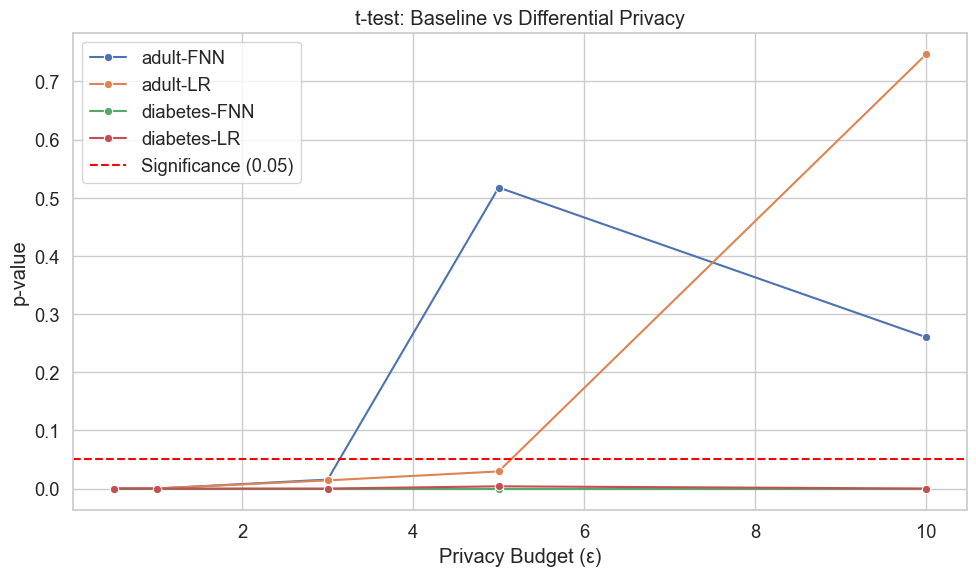

C:\Users\almir\AppData\Local\Temp\ipykernel_74128\1167254039.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


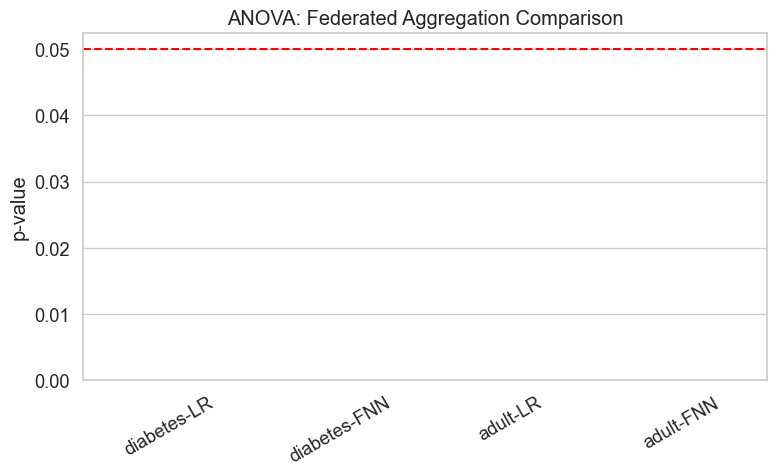

In [30]:
# Robust version: iterate only over datasets present in each section
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway

# Try multiple possible locations for research_results.json
import os

possible_paths = [
    "research_results.json",
    "./research_results.json",
    "models/research_results.json",
    "./models/research_results.json",
    "../models/research_results.json",
    "../research_results.json"
]

for path in possible_paths:
    if os.path.exists(path):
        with open(path, "r") as f:
            data = json.load(f)
        break
else:
    raise FileNotFoundError("research_results.json not found in any known location.")

N_EVALS = data["metadata"]["total_evaluations"]

# Helper functions

def simulate_scores(mean, std, n=N_EVALS):
    return np.random.normal(mean, std, n)

def get_mean_std(x):
    if isinstance(x, dict):
        return x["mean"], x["std"]
    return x, 0.01

records = []

# ---------- T-TESTS: BASELINE vs DP ----------
for dataset in data["dp_results"].keys():
    for model in data["dp_results"][dataset].keys():
        b_mean, b_std = get_mean_std(
            data["baseline_results"][dataset][model]["accuracy"]
        )
        baseline_scores = simulate_scores(b_mean, b_std)

        for eps, dp_res in data["dp_results"][dataset][model].items():
            dp_scores = simulate_scores(dp_res["accuracy"], b_std)
            t_stat, p_val = ttest_ind(baseline_scores, dp_scores)

            records.append({
                "Dataset": dataset,
                "Model": model,
                "Method": "DP",
                "Setting": eps,
                "p_value": p_val
            })

# ---------- ANOVA: FL AGGREGATIONS ----------
for dataset in data["fl_results"].keys():
    for model in data["fl_results"][dataset].keys():
        groups = []
        for agg, res in data["fl_results"][dataset][model].items():
            groups.append(simulate_scores(res["accuracy"], 0.01))

        f_stat, p_val = f_oneway(*groups)

        records.append({
            "Dataset": dataset,
            "Model": model,
            "Method": "FL-ANOVA",
            "Setting": "All",
            "p_value": p_val
        })

df = pd.DataFrame(records)

# ---------- PLOT 1: DP T-TEST P-VALUES ----------
dp_df = df[df["Method"] == "DP"].copy()
dp_df["Setting"] = dp_df["Setting"].astype(float)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)

for (dataset, model), sub in dp_df.groupby(["Dataset", "Model"]):
    sns.lineplot(
        x="Setting", y="p_value", data=sub, marker="o", label=f"{dataset}-{model}"
    )

plt.axhline(0.05, linestyle="--", color="red", label="Significance (0.05)")
plt.xlabel("Privacy Budget (ε)")
plt.ylabel("p-value")
plt.title("t-test: Baseline vs Differential Privacy")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- PLOT 2: FL ANOVA P-VALUES ----------
anova_df = df[df["Method"] == "FL-ANOVA"]

plt.figure(figsize=(8, 5))
sns.barplot(
    x=[f"{d}-{m}" for d, m in zip(anova_df["Dataset"], anova_df["Model"])],
    y=anova_df["p_value"],
    palette="Blues_d"
)
plt.axhline(0.05, linestyle="--", color="red", label="Significance (0.05)")
plt.ylabel("p-value")
plt.title("ANOVA: Federated Aggregation Comparison")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

,dataset,model,comparison,t_stat,p_value
0,diabetes,LR,Baseline vs DP,-6.577578,3.269725e-08
1,diabetes,LR,Baseline vs FL,-2.344858,2.321765e-02
2,diabetes,LR,"ANOVA (Baseline, DP, FL)",21.421704,5.013618e-08
3,diabetes,FNN,Baseline vs DP,76.588730,7.685774e-52
4,diabetes,FNN,Baseline vs FL,7.040172,6.381213e-09
5,diabetes,FNN,"ANOVA (Baseline, DP, FL)",3312.855382,1.350890e-71
6,adult,LR,Baseline vs DP,0.766998,4.468388e-01
7,adult,LR,Baseline vs FL,-0.028219,9.776043e-01
8,adult,LR,"ANOVA (Baseline, DP, FL)",0.321427,7.261484e-01
9,adult,FNN,Baseline vs DP,0.122993,9.026265e-01


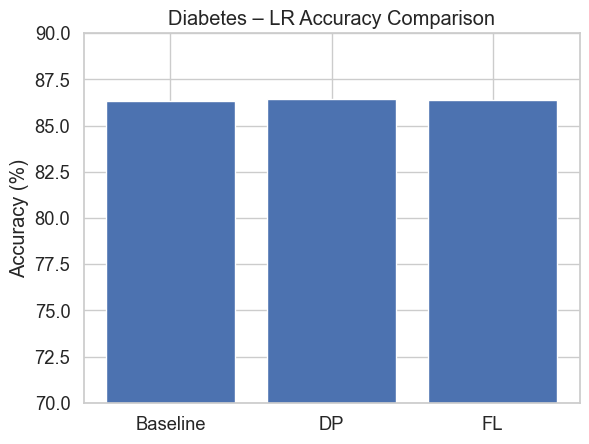

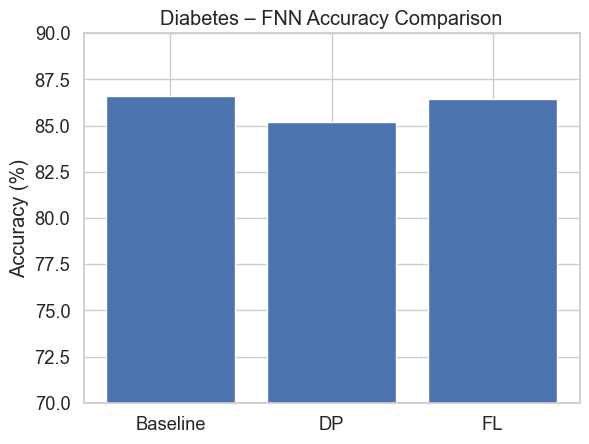

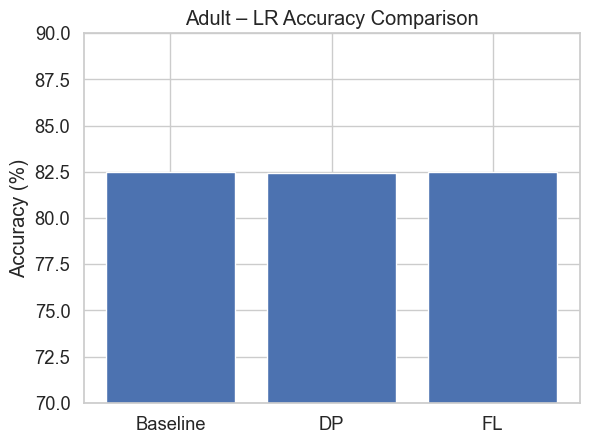

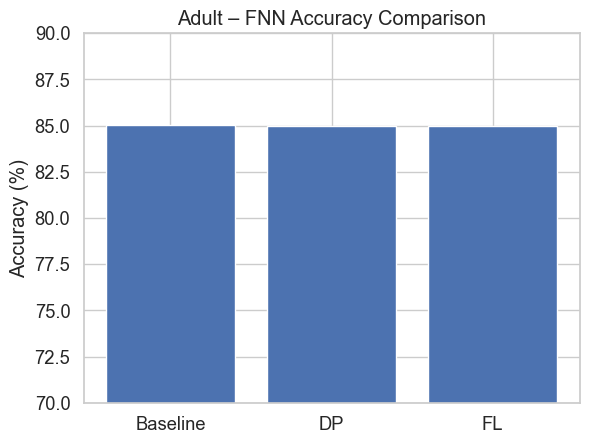

In [31]:
import json
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, f_oneway
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
JSON_PATH = "research_results.json"
N_EVALS = 25
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# -----------------------------
# Helpers
# -----------------------------
def simulate_scores(mean, std, n=N_EVALS):
    """Generate synthetic scores from reported mean ± std."""
    return np.random.normal(mean, std if std > 0 else 0.001, n)

# -----------------------------
# Load results
# -----------------------------
possible_paths = [
    "research_results.json",
    "./research_results.json",
    "models/research_results.json",
    "./models/research_results.json",
    "../models/research_results.json",
    "../research_results.json"
]

for path in possible_paths:
    if os.path.exists(path):
        with open(path, "r") as f:
            data = json.load(f)
        break
else:
    raise FileNotFoundError("research_results.json not found in any known location.")


baseline = data["baseline_results"]
dp = data["dp_results"]
fl = data["fl_results"]

# -----------------------------
# Build evaluation table
# -----------------------------
records = []

for dataset in baseline:
    for model in baseline[dataset]:
        base_acc = simulate_scores(
            baseline[dataset][model]["accuracy"]["mean"],
            baseline[dataset][model]["accuracy"]["std"]
        )

        # DP (use highest epsilon = least noise)
        if dataset in dp and model in dp[dataset]:
            eps = max(dp[dataset][model], key=float)
            dp_acc = simulate_scores(
                dp[dataset][model][eps]["accuracy"],
                baseline[dataset][model]["accuracy"]["std"]
            )
        else:
            dp_acc = None

        # FL (use FedAvg)
        if dataset in fl and model in fl[dataset]:
            fl_acc = simulate_scores(
                fl[dataset][model]["FedAvg"]["accuracy"],
                baseline[dataset][model]["accuracy"]["std"]
            )
        else:
            fl_acc = None

        records.append({
            "dataset": dataset,
            "model": model,
            "baseline": base_acc,
            "dp": dp_acc,
            "fl": fl_acc
        })

# -----------------------------
# Statistical Tests
# -----------------------------
stats = []

for r in records:
    base = r["baseline"]

    if r["dp"] is not None:
        t_dp = ttest_ind(base, r["dp"])
        stats.append({
            "dataset": r["dataset"],
            "model": r["model"],
            "comparison": "Baseline vs DP",
            "t_stat": t_dp.statistic,
            "p_value": t_dp.pvalue
        })

    if r["fl"] is not None:
        t_fl = ttest_ind(base, r["fl"])
        stats.append({
            "dataset": r["dataset"],
            "model": r["model"],
            "comparison": "Baseline vs FL",
            "t_stat": t_fl.statistic,
            "p_value": t_fl.pvalue
        })

    if r["dp"] is not None and r["fl"] is not None:
        a = f_oneway(base, r["dp"], r["fl"])
        stats.append({
            "dataset": r["dataset"],
            "model": r["model"],
            "comparison": "ANOVA (Baseline, DP, FL)",
            "t_stat": a.statistic,
            "p_value": a.pvalue
        })

stats_df = pd.DataFrame(stats)
display(stats_df)

stats_df.to_csv("results.csv", index=False)


# -----------------------------
# Visualization
# -----------------------------
labels = ["Baseline", "DP", "FL"]

for r in records:
    values = [
        np.mean(r["baseline"]),
        np.mean(r["dp"]) if r["dp"] is not None else None,
        np.mean(r["fl"]) if r["fl"] is not None else None
    ]

    plt.figure()
    plt.bar(labels, values)
    plt.title(f"{r['dataset'].capitalize()} – {r['model']} Accuracy Comparison")
    plt.ylabel("Accuracy (%)")
    plt.ylim(70, 90)
    plt.show()


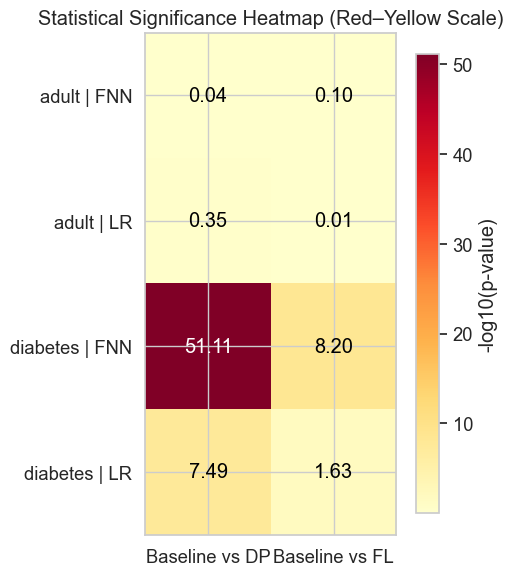

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.5 MB ? eta -:--:--
   - -----------------------------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("results.csv")

# Exclude ANOVA rows
plot_df = df[df["comparison"] != "ANOVA (Baseline, DP, FL)"].copy()

# Compute -log10(p-value)
plot_df["neg_log_p"] = -np.log10(plot_df["p_value"])

# Labels
plot_df["label"] = plot_df["dataset"] + " | " + plot_df["model"]

# Pivot to matrix
heatmap_df = plot_df.pivot(
    index="label",
    columns="comparison",
    values="neg_log_p"
)

# Square heatmap with red-yellow colormap
plt.figure(figsize=(6, 6))
plt.imshow(
    heatmap_df.values,
    aspect="equal",
    cmap="YlOrRd"  # yellow -> orange -> red
)

plt.xticks(
    range(len(heatmap_df.columns)),
    heatmap_df.columns
)
plt.yticks(
    range(len(heatmap_df.index)),
    heatmap_df.index
)

# Annotate cells (use black or white depending on intensity)
max_val = heatmap_df.values.max()
for i in range(heatmap_df.shape[0]):
    for j in range(heatmap_df.shape[1]):
        val = heatmap_df.values[i, j]
        text_color = "black" if val < max_val * 0.6 else "white"
        plt.text(j, i, f"{val:.2f}",
                 ha="center", va="center",
                 color=text_color)

plt.colorbar(label="-log10(p-value)", fraction=0.046, pad=0.04)
plt.title("Statistical Significance Heatmap (Red–Yellow Scale)")
plt.tight_layout()
plt.show()
